In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification
import logging
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pickle

In [12]:
# finance_df = pd.read_csv('finance_df.csv')
# result_filtered_future = pd.read_csv('result_filtered_future.csv')

00:43:46 - cmdstanpy - INFO - Chain [1] start processing
00:43:46 - cmdstanpy - INFO - Chain [1] done processing


            ds         yhat   yhat_lower   yhat_upper
771 2024-04-29  1276.159314  1246.260767  1304.156015
772 2024-04-30  1277.658595  1246.194247  1306.982625
773 2024-05-01  1280.497171  1251.512685  1309.716994
774 2024-05-02  1279.184494  1249.085306  1308.472304
775 2024-05-03  1280.479880  1251.167119  1309.621419
776 2024-05-06  1296.536714  1268.480313  1326.777124
777 2024-05-07  1303.831340  1274.587464  1332.733324
778 2024-05-08  1305.645901  1277.084805  1337.780946
779 2024-05-09  1311.051717  1283.586758  1342.295176
780 2024-05-10  1317.583027  1287.579782  1347.495747
781 2024-05-11  1322.577953  1294.238776  1350.760386


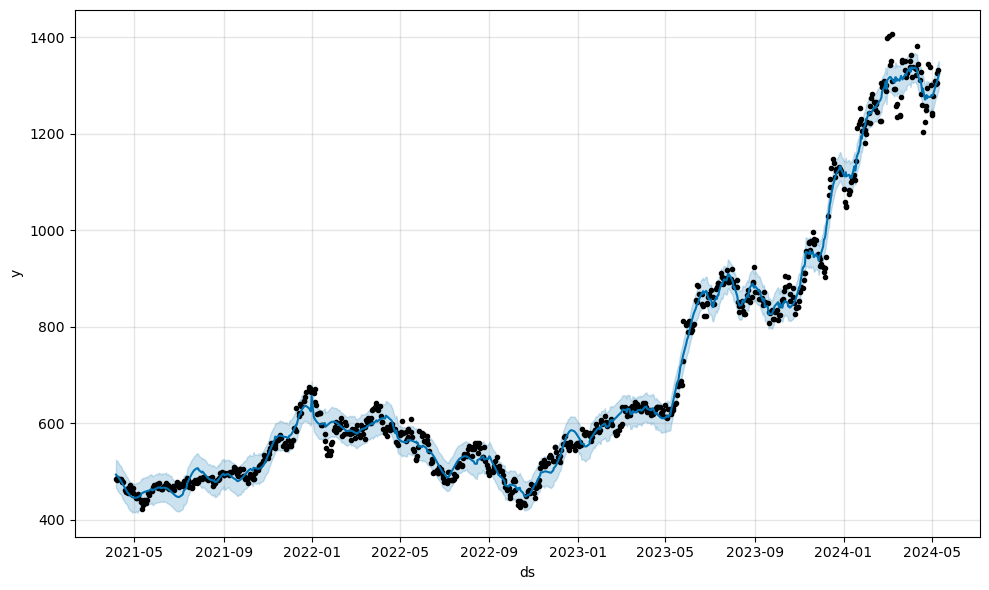

In [13]:
# 저장된 모델 파라미터를 파일로 저장
def prophet_model(ticker, start_date, end_date_1):
    
    # 저장된 모델 파라미터를 불러오는 함수
    ticker = ticker
    start_date = start_date
    end_date_1 = end_date_1 
    finance_df,result_filtered_future = bertcode(ticker,start_date,end_date_1)
    def load_prophet_model_parameters(file_path):
        with open(file_path, 'rb') as f:
            model_params = pickle.load(f)
        return model_params
        
    file_path = f"prophet_model_parameters_{ticker}.pkl"
    loaded_model_parameters = load_prophet_model_parameters(file_path)
    
    # Prophet 모델 생성 및 파라미터 설정
    loaded_model = Prophet(
        changepoint_prior_scale=loaded_model_parameters['changepoint_prior_scale'],
        seasonality_prior_scale=loaded_model_parameters['seasonality_prior_scale'],
        holidays_prior_scale=loaded_model_parameters['holidays_prior_scale'],
        seasonality_mode=loaded_model_parameters['seasonality_mode'],
        changepoint_range=loaded_model_parameters['changepoint_range'],
        yearly_seasonality=loaded_model_parameters['yearly_seasonality'],
        weekly_seasonality=loaded_model_parameters['weekly_seasonality'],
        daily_seasonality=loaded_model_parameters['daily_seasonality'],
        growth=loaded_model_parameters['growth'],
        n_changepoints=loaded_model_parameters['n_changepoints']
    )
    loaded_model.add_country_holidays(country_name='US')
    
    loaded_model.add_regressor('predict')
    
    # 데이터 학습
    loaded_model.fit(finance_df)
    future = loaded_model.make_future_dataframe( periods = 1)
    future['predict'] = result_filtered_future['predict'].values
    # 주가 예측
    forecast = loaded_model.predict(future)

    return finance_df, forecast 

# # forecast.columns ->
# '''
#   Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
#        'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
#        'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
#        'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
#        'multiplicative_terms', 'multiplicative_terms_lower',
#        'multiplicative_terms_upper', 'yhat'],
#       dtype='object')
# ''' 

# # 모델 예측 결과 출력
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# # 모델 예측 그래프 출력
# fig = loaded_model.plot(forecast)

# plt.show(fig)


In [15]:

# def simulate_trading(start_date, end_date_1,end_date_2,initial_capital):
#     # 입력된 날짜 범위로 데이터 필터링
#     filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
#     filtered_df_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]

#     # 현재 자본 및 보유 주식 수 초기화
#     current_capital = initial_capital
#     shares_owned = 0

#     # 현재 포지션 초기화
#     position = 'None'

#     # 실제 및 예측 주식 가격 설정
#     actual_prices = filtered_df.set_index('ds')['y']
#     predicted_prices = filtered_df_forecast.set_index('ds')['yhat']

#     # 거래 기록 초기화
#     trading_history = []

#     # 시뮬레이션 시작
#     for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
#         predicted_change = predicted_next_day_price - today_price

#         # 매수 조건
#         if predicted_change > 0 and position != 'Hold':
#             shares_to_buy = current_capital / today_price
#             shares_owned += shares_to_buy
#             current_capital -= shares_to_buy * today_price
#             position = 'Hold'
#             trading_history.append((date, '매수', today_price, predicted_next_day_price))

#         # 매도 조건
#         elif predicted_change < 0 and position == 'Hold':
#             current_capital += shares_owned * today_price
#             shares_owned = 0
#             position = 'None'
#             trading_history.append((date, '매도', today_price, predicted_next_day_price))

#         # 보유 조건
#         elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
#             trading_history.append((date, '보유', today_price, predicted_next_day_price))

#         # 조치 없음 또는 보유
#         else:
#             if position == 'Hold':
#                 trading_history.append((date, '보유', today_price, predicted_next_day_price))
#             else:
#                 trading_history.append((date, '조치 없음', today_price, predicted_next_day_price))

#     # 최종 자본 및 수익률 계산
#     final_capital = current_capital + (shares_owned * actual_prices.iloc[-1])
#     profit = final_capital - initial_capital
#     return_rate = (profit / initial_capital) * 100

#     return trading_history, final_capital, return_rate

# # 주어진 날짜 범위로 거래 시뮬레이션 실행
# start_date = '2024-04-05'
# end_date_1 = '2024-05-10'
# end_date_2 = '2024-05-11'
# initial_capital = 100000000.0
# trading_history, final_capital, return_rate = simulate_trading(start_date, end_date_1,end_date_2,initial_capital)

# # 거래 기록 출력
# for record in trading_history:
#     print(f"{record[0]} - {record[1]}: 현재 가격 ${record[2]:.3f}, 예측 다음날 가격 ${record[3]:.3f}")

# # 최종 자본 및 수익률 출력
# print(f"최종 자본: ${final_capital:.2f}")
# print(f"수익률: {return_rate:.2f}%")
